In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt  # for making figures
%matplotlib inline

In [4]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [9]:
# build the vocabulary of characters and mappings to/from integers

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

In [14]:
# tuning the model:

block_size = 3  # context length: how many characters do we take to predict the next one?
n_embd = 10  # number of dimensions in embedding
layer_1_input = block_size * n_embd
n_hidden = 200
batch_size = 32
max_steps = 200000

In [15]:
# building the dataset

def build_dataset(words):
    X, Y = [], []  # X is the array of the input characters, Y is the output for those input characters
    
    for w in words:
        
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '---->', ch)
            context = context[1:] + [ix]  # crop and append for next character's context
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [130]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((layer_1_input, n_hidden), generator=g) * 0.2  
b1 = torch.randn((n_hidden), generator=g) * 0.01
W2 = torch.randn((n_hidden, 27), generator=g) * 0.01
b2 = torch.randn((vocab_size), generator=g) * 0  # biases can be 0 as well at initialization, 0.01 can help with some entropy and optimization
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)  # number of parameters in total

11897

In [131]:
lri = []
lossi = []
stepi = []

In [ ]:
for i in range(max_steps):

    # minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X, Y
    
    # forward pass
    emb = C[Xb]  # embed characters to vectors
    embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
    hpreact = embcat @ W1 + b1  # hidden layer pre-activation
    h = torch.tanh(hpreact)  # hidden layer
    logits = h @ W2 + b2  # output layer 
    loss = F.cross_entropy(logits, Yb)  # loss function 
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    stepi.append(i)
    lossi.append(loss.log10().item())

#    break

      0/ 200000:3.2465
  10000/ 200000:1.9043
  20000/ 200000:1.9004
  30000/ 200000:1.9465
  40000/ 200000:2.1656
  50000/ 200000:2.0071
  60000/ 200000:2.0826
  70000/ 200000:2.4228
  80000/ 200000:2.3109
  90000/ 200000:2.1167
 100000/ 200000:2.2166
 110000/ 200000:1.8038


In [ ]:
plt.plot(lossi)

In [ ]:
#this decorator disables gradient tracking
@torch.no_grad()  # pytorch will not keep track of gradients of tensors here, as they are not needed. To improve efficiency
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]

    emb = C[x]  # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1)  # (N, n_hidden)
    logits = h @ W2 + b2  # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

In [59]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size  # initialize with all '...'
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]  # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        # if we sample '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))  # decode and print generated word

mora.
mayah.
seel.
nah.
yal.
ren.
ruchadrael.
adeeronelin.
shy.
jenne.
elios.
anaraelyn.
malkia.
noshuberlihamies.
kendreth.
konnie.
con.
brence.
ryyah.
fael.


In [ ]:
# -------------------- notes and stuff -------------------- #

In [60]:
# 4-dimensional example of the issue
# logits = torch.tensor([-3.0, 5.0, 0.0, 2.0])
# when we initialize with high values, our loss is terrible, because the model makes confident incorrect guesses due to high values at the wrong values
# logits = torch.randn(4) * 10  # like in this example, where we multiply it by a large number to show this

# to solve this, we make all logits equal
logits = torch.tensor([1.0, 1.0, 1.0, 1.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

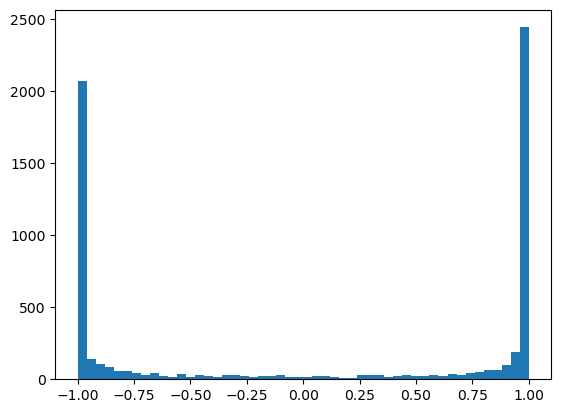

In [123]:
# h.shape
# torch.Size([32, 200])  # 200 neurons for each of the 32 examples (3 letter context) in that batch

# lets plot a histogram of h
plt.hist(h.view(-1).tolist(), 50);  # semicolon supresses some unneeded text along with output from displaying
# most values are -1 or 1

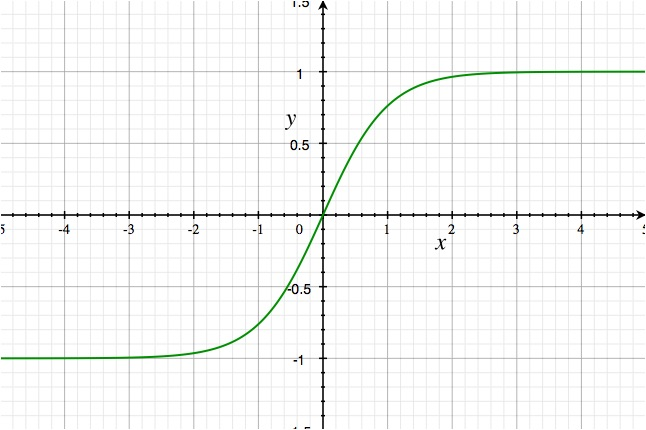

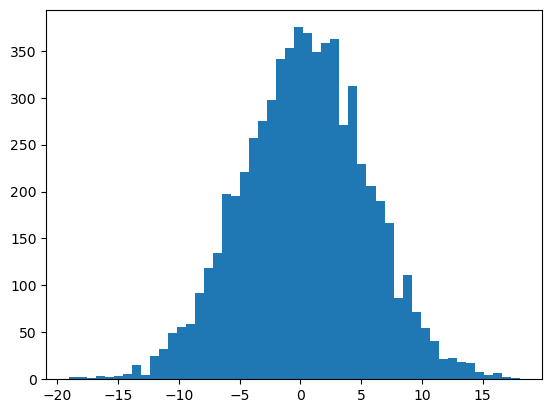

In [110]:
# to see why that is the case, we need to see the h pre-activations
plt.hist(hpreact.view(-1).tolist(), 50);

# as we can see, a large number of values are above 2 or below -2, so when they are put through tanh,
# they get squashed to 1 and -1

In [ ]:
# to understand why this is bad, let's look at some code from micrograd

# the tanh function from our 'Value' class
# def tanh(self):
#         x = self.data
#         t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
#         out = Value(t, (self, ), 'tanh')

#         def _backward():
#             self.grad += (1 - t**2) * out.grad
#         out._backward = _backward
        
#         return out

# now, if we have large values (in both -ve and +ve), and apply tanh to them, we will get t = 1 or t = -1 on applying tanh
# now when we calculate backward() on them, here's what will happen
# self.grad += (1 - t**2) * out.grad
# t = 1 or t = -1
# therefore, our self.grad will become, no matter what out.grad is,
# self.grad += (1 - 1) * out.grad ==> self.grad += 0 * out.grad ==> self.grad += 0
# we are 'killing' the gradient and any further gradients along that line, all will be 0
# so we are stopping backprop through the tanh units for these values
# this is kind of like a permanent brain damage in the mind of the network
# this happens in activation functions which have 'flat tails', like tanh, ReLu, sigmoid
# some other activation functions will not suffer from this issue as much, because they don't have a flat tail, like leaky ReLu, ELU, maxout

# if our t = 0
# self.grad += (1 - 0) * out.grad ==> self.grad += 1 * out.grad ==> self.grad += out.grad
# so the tanh unit is sort of 'inactive', and our gradient just passes through
# but note that this isn't a BAD thing like our previous situation with the 1 or -1

# but what this tells us about the tanh in general by seeing this eqn: (1 - t**2) <--- this is the derivative of tanh
# the gradient flowing through tanh can only ever decrease
# and the amount that it decreases is proportional to a square function

# to solve this issue, we will multiply the W1 and b1 by a very small number, for example, 0.01
# as they are the ones causing hpreact to have large values, and thus the problem in h
# hpreact = embcat @ W1 + b1

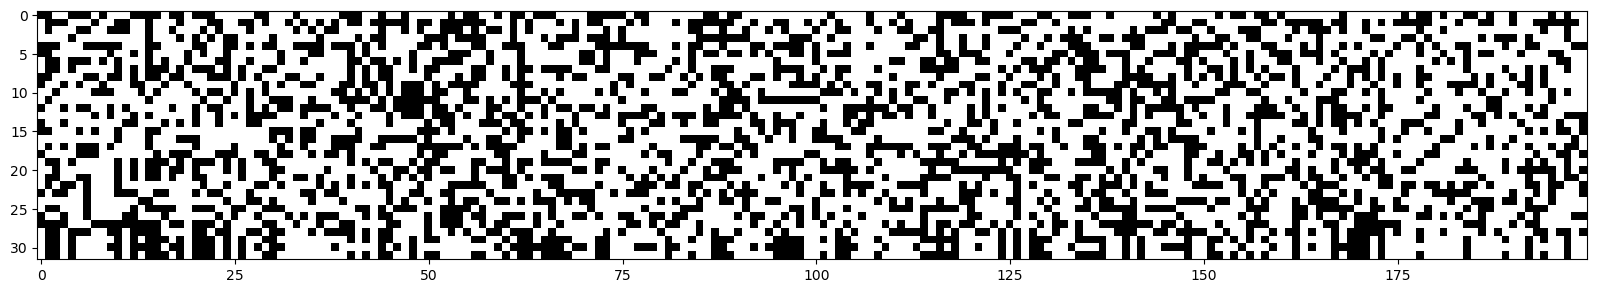

In [112]:
# we are trying to see how often values in h are in this 'bad' region of -1 or 1
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
# h.abs() > 0.99  --> boolean ---> white if true, black if false

# turns out, quite often for now
# a lot of it is white
# so in all these cases, the backward gradient would get 'destroyed'

# it would be really bad, if we had for any one of these 200 neurons, an entire dead column
# this would be called a dead neuron, it will never learn
# fortunately we don't have any here like that

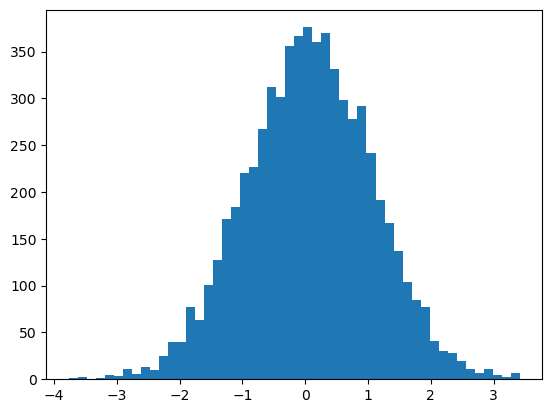

In [134]:
plt.hist(hpreact.view(-1).tolist(), 50);

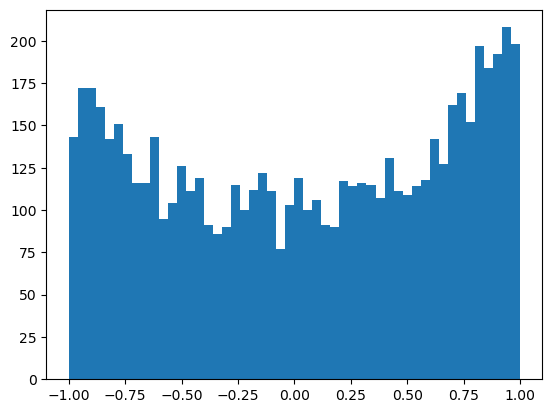

In [133]:
plt.hist(h.view(-1).tolist(), 50);

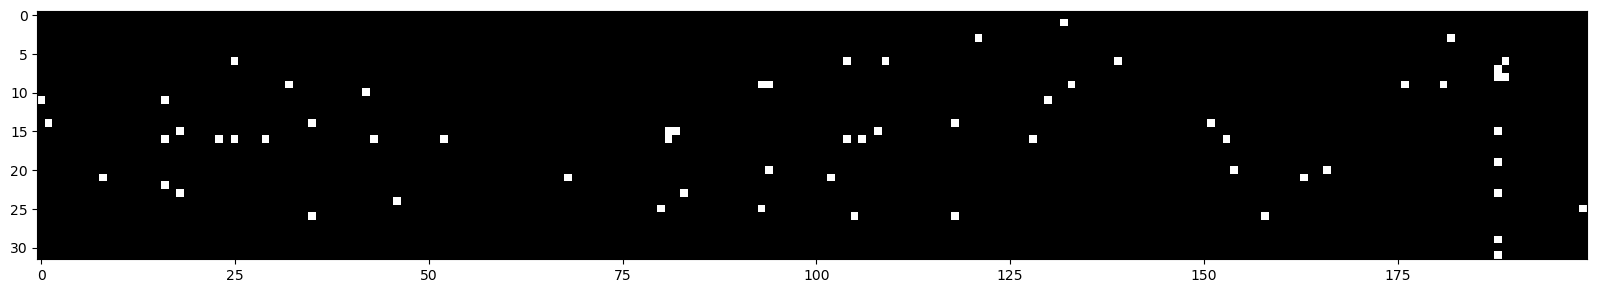

In [135]:
# we are trying to see how often values in h are in this 'bad' region of -1 or 1
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
# h.abs() > 0.99  --> boolean ---> white if true, black if false